In [83]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import TimeSeriesTensor, mape, extract_data, create_evaluation_df
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [84]:
!git clone https://github.com/Arghyam-Team/KRSPrediction.git

fatal: destination path 'KRSPrediction' already exists and is not an empty directory.


In [85]:
import sqlite3
db_file = '/content/KRSPrediction/data/pythonsqlite.db'
conn = sqlite3.connect(db_file)
cur = conn.cursor()
sql = "SELECT water.date, water.storage_tmc, water.inflow_cusecs, water.outflow_cusecs, weather.max_temp, weather.visibility, weather.wind, weather.humidity, weather.cloudcover FROM water INNER JOIN weather ON  water.reservoir='krs' AND weather.location='karnataka' AND water.date = weather.date"
cur.execute(sql)
rows = cur.fetchall() # rows is a list of tuples (date, tmc,inflow,outflow,maxtemp,vis,wind,hum,cloud)

In [86]:
krs = pd.DataFrame(rows, columns=['date', 'present_storage_tmc', 'inflow', 'outflow', 'max_temp', 'visibility', 'wind', 'humidity', 'cloudcover'])

In [87]:
krs.head(2)

,date,present_storage_tmc,inflow,outflow,max_temp,visibility,wind,humidity,cloudcover
0,2011-01-01,46.42,2029,2000.0,28.1,6.7,11.2,71.39,36.7
1,2011-01-02,46.54,3084,1490.0,28.0,6.2,10.3,72.90,51.4


In [88]:
krs = krs.drop_duplicates(subset=["date"])

In [89]:
krs.date = pd.to_datetime(krs.date)
krs['inflow'] = pd.to_numeric(krs.inflow, errors='coerce')

In [90]:
krs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3530 entries, 0 to 3534
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3530 non-null   datetime64[ns]
 1   present_storage_tmc  3530 non-null   float64       
 2   inflow               3529 non-null   float64       
 3   outflow              3530 non-null   float64       
 4   max_temp             3530 non-null   float64       
 5   visibility           3530 non-null   float64       
 6   wind                 3530 non-null   float64       
 7   humidity             3530 non-null   float64       
 8   cloudcover           3530 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 275.8 KB


In [91]:
krs['inflow_tmc'] = krs['inflow'] /11000
krs['outflow_tmc'] = krs['outflow'] / 11000

In [92]:
krs.sort_values(by=['date'], inplace=True, ascending=True)

In [93]:
krs.set_index('date', inplace=True)
krs = krs.sort_index(axis=1)

In [94]:
krs.head(2)

,cloudcover,humidity,inflow,inflow_tmc,max_temp,outflow,outflow_tmc,present_storage_tmc,visibility,wind
date,,,,,,,,,,
2010-09-30,79.6,81.05,2706.0,0.246000,29.4,6840.0,0.621818,46.18,5.2,11.2
2010-12-31,51.0,70.80,2668.0,0.242545,27.5,6795.0,0.617727,45.81,6.9,11.2


In [95]:
#time series data on which model needs to be trained on, features contain the column names
ts_data_load = krs[[ "present_storage_tmc", "inflow_tmc", "outflow_tmc", "max_temp", "visibility", "humidity", "wind"]]
ts_data_load.sort_index(axis = 1)
features = len(ts_data_load.columns)
#features, ts_data_load.head(2), ts_data_load.tail(2)

In [96]:
valid_st_data_load = "2018-01-01 00:00:00"
test_st_data_load = "2019-05-02 00:00:00"

In [97]:
ts_data_load[ts_data_load.index==valid_st_data_load]

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2018-01-01,25.55,0.026455,0.313182,28.0,6.6,65.5,11.0


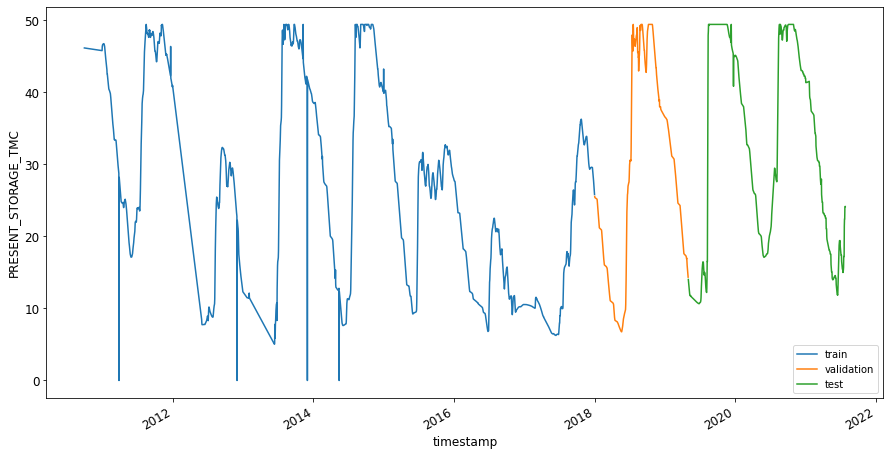

In [98]:
ts_data_load[ts_data_load.index < valid_st_data_load][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["present_storage_tmc"]
    ].rename(columns={"present_storage_tmc": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("PRESENT_STORAGE_TMC", fontsize=12)
plt.show()

In [99]:
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load]

In [100]:
train.shape

(2250, 7)

In [101]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["present_storage_tmc"]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [102]:
flist = list(ts_data_load.columns)

In [103]:
T = 30
HORIZON = 1
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][flist]

X_scaler = MinMaxScaler()
train[flist] = X_scaler.fit_transform(train)
train.sample(10)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2016-03-17,0.280485,0.003384,0.034538,0.700935,0.683333,0.490187,0.086124
2013-12-18,0.811325,0.033749,0.040694,0.369159,0.483333,0.560047,0.076555
2012-06-07,0.156926,0.003259,0.002069,0.560748,0.800000,0.509080,0.177033
2016-05-21,0.208291,0.001593,0.002971,0.649533,0.883333,0.524019,0.115516
2015-08-28,0.544388,0.086001,0.085099,0.509346,0.733333,0.707381,0.146275
2013-10-13,0.946613,0.019447,0.038371,0.415888,0.716667,0.650557,0.146275
2013-09-21,0.972497,0.137017,0.039132,0.369159,0.650000,0.754979,0.152427
2015-04-23,0.326390,0.002756,0.043107,0.766355,0.650000,0.637668,0.114833
2012-08-25,0.487361,0.031831,0.044953,0.359813,0.466667,0.799795,0.103213


In [104]:
train = train.dropna(axis = 0, how ='any')
train.isna().sum()

present_storage_tmc    0
inflow_tmc             0
outflow_tmc            0
max_temp               0
visibility             0
humidity               0
wind                   0
dtype: int64

In [105]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}
print(tensor_structure)
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    days=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= back_ts_data) & (ts_data_load.index < test_st_data_load)][
    flist
]
valid[flist] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "present_storage_tmc", HORIZON, tensor_structure, freq='D')

{'X': (range(-29, 1), ['present_storage_tmc', 'inflow_tmc', 'outflow_tmc', 'max_temp', 'visibility', 'humidity', 'wind'])}


In [106]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [107]:
LATENT_DIM = T
BATCH_SIZE = 64
EPOCHS = (
    100
)

In [108]:
model = Sequential()
model.add(GRU(LATENT_DIM, return_sequences=True,input_shape=(T, features)))
#model.add(GRU(LATENT_DIM, input_shape=(T, 3)))
model.add(GRU(LATENT_DIM))
model.add(Dense(HORIZON))

In [109]:
model.compile(optimizer="adam", loss="mse")


In [110]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 30, 30)            3510      
_________________________________________________________________
gru_3 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 9,121
Trainable params: 9,121
Non-trainable params: 0
_________________________________________________________________


In [111]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


In [112]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/100
32/32 [==============================] - 4s 48ms/step - loss: 0.0839 - val_loss: 0.0274
Epoch 2/100
32/32 [==============================] - 1s 29ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 4/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 5/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/100
32/32 [==============================] - 1s 30ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/100
32/32 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 8.3977e-04
Epoch 8/100
32/32 [==============================] - 1s 29ms/step - loss: 0.0010 - val_loss: 7.0049e-04
Epoch 9/100
32/32 [==============================] - 1s 28ms/step - loss: 0.0010 - val_loss: 6.5171e-04
Epoch 10/100
32/32 [==============================] - 1s 28ms/step - loss: 9.9983e-04 - 

In [113]:
model.save("30daysto1day")

INFO:tensorflow:Assets written to: 30daysto1day/assets


INFO:tensorflow:Assets written to: 30daysto1day/assets


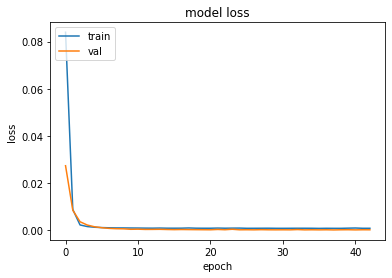

In [114]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

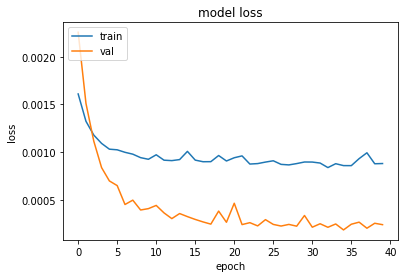

In [115]:
# summarize history for loss
plt.plot(model_history.history['loss'][3:])
plt.plot(model_history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [116]:
ts_data_test = ts_data_load.copy()[test_st_data_load:][flist]
ts_data_test[flist] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "present_storage_tmc", HORIZON, tensor_structure, freq='D')


In [117]:
ts_data_test_inputs['X'].shape

(690, 30, 7)

In [118]:
def create_evaluation_df1(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(
        predictions, columns=["t+" + str(t) for t in range(1, H + 1)]
    )
    
    eval_df["timestamp"] = test_inputs.dataframe.index
    print(eval_df.shape, eval_df.head(2))

    #eval_df = pd.melt(
    #    eval_df, id_vars="timestamp", value_name="prediction", var_name="h"
    #)
    values = ['t+'+str(i) for i in range(1, H+1)]
    
    eval_df = pd.melt(
        eval_df, id_vars="timestamp", value_vars=values, value_name="prediction"
    )
    print(eval_df.shape, eval_df.head(2))
    eval_df["actual"] = np.transpose(test_inputs["target"]).ravel()
    eval_df[["prediction", "actual"]] = scaler.inverse_transform(
        eval_df[["prediction", "actual"]]
    )
    return eval_df

In [119]:
ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df1(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.sample(5)

(690, 2)         t+1  timestamp
0  0.234088 2019-05-31
1  0.233464 2019-06-01
(690, 3)    timestamp variable  prediction
0 2019-05-31      t+1    0.234088
1 2019-06-01      t+1    0.233464


,timestamp,variable,prediction,actual
124,2019-10-02,t+1,49.668595,49.4500
613,2021-05-09,t+1,17.842695,17.5480
503,2021-01-19,t+1,41.486197,40.5285
630,2021-05-26,t+1,14.655922,14.2810
465,2020-12-12,t+1,43.138841,43.0200


In [120]:

mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.021427769835395447

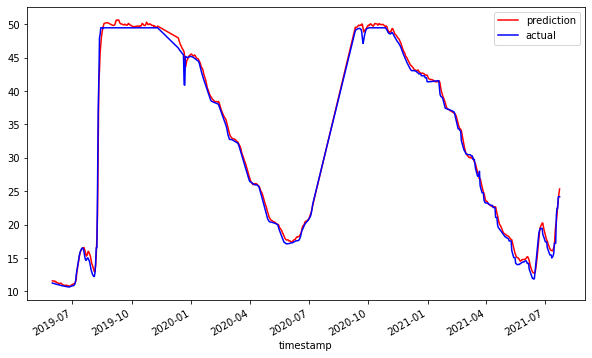

In [121]:
ev_ts_data[ev_ts_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [122]:
ev_ts_data.to_csv("forecast_withdatecolumns.csv")

In [123]:
import datetime
forecast_dates = ev_ts_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_ts_data["date"] = forecast_dates


In [124]:
ev_ts_data.head(2)

,timestamp,variable,prediction,actual,date
0,2019-05-31,t+1,11.575661,11.25,2019-06-01
1,2019-06-01,t+1,11.544778,11.22,2019-06-02


In [125]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [127]:
cp -r '/content/30daysto1day' '/content/gdrive/My Drive/Wave2web/'

In [129]:
#finetuning
T = 30
HORIZON = 1
ftrain = ts_data_load.copy()[flist]

X_scaler = MinMaxScaler()
ftrain[flist] = X_scaler.fit_transform(ftrain)
ftrain.sample(2)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2011-10-01,0.926390,0.013066,0.044891,0.415888,0.483333,0.762885,0.053769
2021-04-21,0.396178,0.000739,0.028362,0.691589,0.466667,0.513560,0.049025


In [132]:
ftrain.last('1D')

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2021-07-25,0.488493,0.053957,0.015142,0.415888,0.483333,0.822377,0.108065


In [135]:
from datetime import date
date.today()

2021-07-25


In [137]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}

ts_train_inp = TimeSeriesTensor(
    dataset=ftrain,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
#back_ts_data = dt.datetime.strptime(date.today(), "%Y-%m-%d %H:%M:%S") - dt.timedelta(
#    days=T - 1
#)


In [138]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=10,
    #validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/10
51/51 [==============================] - 1s 28ms/step - loss: 7.0971e-04


Epoch 2/10
51/51 [==============================] - 1s 29ms/step - loss: 6.7915e-04


Epoch 3/10
51/51 [==============================] - 1s 29ms/step - loss: 6.5478e-04


Epoch 4/10
51/51 [==============================] - 1s 27ms/step - loss: 6.2305e-04


Epoch 5/10
51/51 [==============================] - 1s 25ms/step - loss: 6.4628e-04


Epoch 6/10
51/51 [==============================] - 1s 26ms/step - loss: 6.2758e-04


Epoch 7/10
51/51 [==============================] - 1s 25ms/step - loss: 6.4668e-04


Epoch 8/10
51/51 [==============================] - 1s 28ms/step - loss: 6.1546e-04


Epoch 9/10
51/51 [==============================] - 1s 26ms/step - loss: 6.2888e-04


Epoch 10/10
51/51 [==============================] - 1s 26ms/step - loss: 6.0550e-04


In [139]:
ts_predictions = model.predict(ts_train_inp["X"])

ev_all_data = create_evaluation_df1(ts_predictions, ts_train_inp, HORIZON, y_scaler)
ev_all_data.sample(5)

(3241, 2)         t+1  timestamp
0  0.845711 2011-01-29
1  0.841041 2011-01-30
(3241, 3)    timestamp variable  prediction
0 2011-01-29      t+1    0.845711
1 2011-01-30      t+1    0.841041


,timestamp,variable,prediction,actual
972,2015-02-02,t+1,34.932266,35.23
1485,2016-06-29,t+1,7.623264,8.25
1890,2017-08-08,t+1,17.880223,17.71
1404,2016-04-09,t+1,11.258040,11.41
2259,2018-08-12,t+1,45.890801,45.63


In [140]:

mape(ev_all_data["prediction"], ev_all_data["actual"])

inf

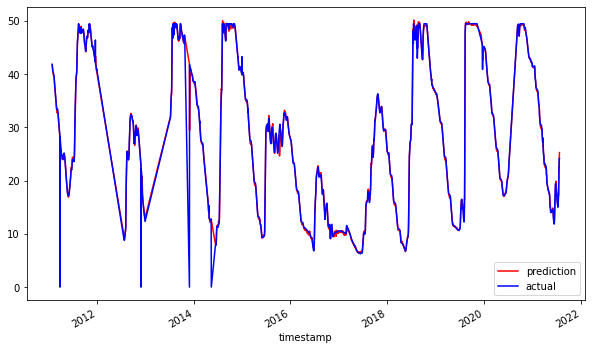

In [142]:
ev_all_data[ev_all_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [143]:
import datetime
forecast_dates = ev_all_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_all_data["date"] = forecast_dates


In [146]:
ev_all_data.to_csv("predictions.csv")

In [147]:
import sqlite3


In [148]:
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

In [149]:
df = pd.read_csv("predictions.csv")

In [150]:
df.head()

,Unnamed: 0,timestamp,variable,prediction,actual,date
0,0,2011-01-29,t+1,41.820400,41.79,2011-01-30
1,1,2011-01-30,t+1,41.589464,41.56,2011-01-31
2,2,2011-01-31,t+1,41.276625,41.30,2011-02-01
3,3,2011-02-01,t+1,41.035273,40.98,2011-02-02
4,4,2011-02-02,t+1,40.736331,40.66,2011-02-03


In [154]:
c.execute("CREATE TABLE PREDICTIONS ([timestamp] integer, [prediction] integer, [actual] integer, [date] integer)")

In [155]:
conn.commit()

In [156]:
conn = sqlite3.connect('predictions.db')  
c = conn.cursor()

In [158]:
df[['timestamp', 'prediction', 'actual', 'date']].to_sql('PREDICTIONS', conn, if_exists='append', index = False)